# Synthetic Tree with Random branch $b \in [1,10]$

In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2

In [2]:
type = "random"
final_level = 4

In [3]:
import os
import pickle
import pandas as pd
import numpy as np
import tqdm as tqdm
from IPython.display import clear_output

# Dense dataset

## Load the data

In [4]:
from data_structure import GeoSpine
from data_structure import HierarchicalData
density = "dense"
folder_path = f"../data/synthetic_{type}_branching_{density}/"
with open(os.path.join(folder_path, "structure/geo_spine.pickle"), "rb") as f:
    geo_spine = pickle.load(f)

# upload csv data
df = pd.read_csv(os.path.join(folder_path, "data.csv"))

spine = GeoSpine(geo_spine)
H_dense = HierarchicalData(df, spine)

## Histogram of counts for the finest level

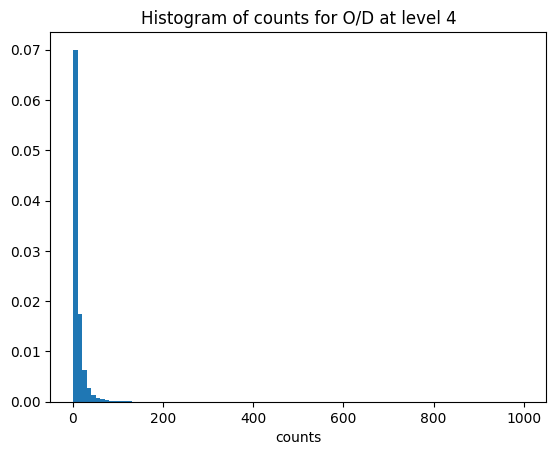

In [5]:
# make historga of count
import matplotlib.pyplot as plt

data_true = H_dense.data_up_to_level(final_level, as_index=False, dtype=int)
plt.hist(data_true["COUNT"], bins=100, density=True)
plt.title(f"Histogram of counts for O/D at level {final_level}")
plt.xlabel("counts")
plt.show()

In [6]:
print("Sparsity of the data ", 1 - len(data_true) / (len(H_dense.spine.get_nodes(level=final_level)) ** 2))

Sparsity of the data  0.5000026423569824


## Apply Stability Histogram

In [7]:
import argparse

epsilons = [1., 10.]
delta = 1E-8
num_experiments = 10
levels: list[tuple] = [(i, i) if i == j else (i, j) for i in range(final_level + 1) for j in range(i, i + 2) if
                       j < final_level + 1]

# mechanisms, epsilons, experiments, levels
num_mechanisms = 3
max_error_dense = np.zeros((num_mechanisms, 2, num_experiments, len(levels)))
false_discovery_rate_dense = np.zeros((num_mechanisms, 2, num_experiments, len(levels)))
false_negative_rate_dense = np.zeros((num_mechanisms, 2, num_experiments, len(levels)))
MAE = np.zeros((num_mechanisms, 2, len(levels)))
std = np.zeros((num_mechanisms, 2, len(levels)))

# generate Namespace containing epsilon and delta
args = argparse.Namespace(delta=delta, final_level=final_level, max_contribution=1, show_tqdm=False,
                          optimizer="greedy_integer", p='inf', integer_true=False, split_method='uniform')

In [8]:
from mechanism import VanillaSH
from metrics import analysis

for e, epsilon in enumerate(epsilons):
    args.epsilon = epsilon
    # for collecting error distribution for multiple experiments
    absolute_error_distribution_epsilon = []
    for i in range(num_experiments):
        print(f"Experiment {i + 1}")
        data_vanillash_dense, running_time_dense = VanillaSH(H_dense, args)
        # for collecting error distribution for multiple levels
        absolute_error_distribution = []
        for j, level in enumerate(tqdm.tqdm(levels, colour="green")):
            workload = [[f"LEVEL{level[0]}_ORIG", f"LEVEL{level[1]}_DEST"]]
            analysis_dict = analysis(data_true=data_true,
                                     dp_data=data_vanillash_dense,
                                     spine=H_dense.spine,
                                     workload=workload)
            max_error_dense[0, e, i, j] = analysis_dict["max_absolute_error"]
            false_discovery_rate_dense[0, e, i, j] = analysis_dict["false_discovery_rate"]
            false_negative_rate_dense[0, e, i, j] = analysis_dict["false_negative_rate"]
            absolute_error_distribution.append(np.abs(analysis_dict["error_distribution"][0]))
        absolute_error_distribution_epsilon.append(absolute_error_distribution)
        # clear jupyter output on the terminal
        clear_output(wait=True)
    # absolute_error_distribution_epsilon is a list of lists that needs to be concatenated
    error_to_add = np.zeros(len(levels))
    std_to_add = np.zeros(len(levels))
    for j in range(len(levels)):
        concantenation = []
        # concatenate the list of lists
        for i in range(num_experiments):
            concantenation.append(absolute_error_distribution_epsilon[i][j])
        # assert they are all the same length
        assert len(set([len(x) for x in concantenation])) == 1
        # flatten the list
        error_to_add[j] = np.mean(np.concatenate(concantenation))
        std_to_add[j] = np.std(np.concatenate(concantenation))
    MAE[0, e] = error_to_add
    std[0, e] = std_to_add

Experiment 10
Querying the full histogram
Applying the DP mechanism
Creating the dataset
Time taken to create the dataset: 2.48 seconds


100%|██████████| 9/9 [00:00<00:00, 11.01it/s]


## Apply VanillaGauss

In [9]:
from mechanism import VanillaGauss

for e, epsilon in enumerate(epsilons):
    args.epsilon = epsilon
    absolute_error_distribution_epsilon = []
    for i in range(num_experiments):
        print(f"Experiment {i + 1}")
        data_vanillagauss, running_time_dense = VanillaGauss(H_dense, args)
        absolute_error_distribution = []
        for j, level in enumerate(tqdm.tqdm(levels, colour="green")):
            workload = [[f"LEVEL{level[0]}_ORIG", f"LEVEL{level[1]}_DEST"]]
            analysis_dict = analysis(data_true=data_true,
                                     dp_data=data_vanillagauss,
                                     spine=H_dense.spine,
                                     workload=workload)
            max_error_dense[1, e, i, j] = analysis_dict["max_absolute_error"]
            false_discovery_rate_dense[1, e, i, j] = analysis_dict["false_discovery_rate"]
            false_negative_rate_dense[1, e, i, j] = analysis_dict["false_negative_rate"]
            absolute_error_distribution.append(np.abs(analysis_dict["error_distribution"][0]))
        absolute_error_distribution_epsilon.append(absolute_error_distribution)
        # clear jupyter output on the terminal
        clear_output(wait=True)
    # absolute_error_distribution_epsilon is a list of lists that needs to be concatenated
    error_to_add = np.zeros(len(levels))
    std_to_add = np.zeros(len(levels))
    for j in range(len(levels)):
        concantenation = []
        # concatenate the list of lists
        for i in range(num_experiments):
            concantenation.append(absolute_error_distribution_epsilon[i][j])
        # assert they are all the same length
        assert len(set([len(x) for x in concantenation])) == 1
        # flatten the list
        error_to_add[j] = np.mean(np.concatenate(concantenation))
        std_to_add[j] = np.std(np.concatenate(concantenation))
    MAE[1, e] = error_to_add
    std[1, e] = std_to_add

Experiment 10
Querying the full histogram
Applying the DP mechanism
Creating the dataset
Time taken to create the dataset: 2.08 seconds


100%|██████████| 9/9 [00:01<00:00,  6.62it/s]


## Apply GaussOpt

In [10]:
from mechanism import GaussOpt_destination

for e, epsilon in enumerate(epsilons):
    args.epsilon = epsilon
    absolute_error_distribution_epsilon = []
    for i in range(num_experiments):
        print(f"Experiment {i + 1}")
        data_gaussopt, running_time_dense = GaussOpt_destination(H_dense, args)
        absolute_error_distribution = []
        for j, level in enumerate(tqdm.tqdm(levels, colour="green")):
            workload = [[f"LEVEL{level[0]}_ORIG", f"LEVEL{level[1]}_DEST"]]
            analysis_dict = analysis(data_true=data_true,
                                     dp_data=data_gaussopt,
                                     spine=H_dense.spine,
                                     workload=workload)
            max_error_dense[2, e, i, j] = analysis_dict["max_absolute_error"]
            false_discovery_rate_dense[2, e, i, j] = analysis_dict["false_discovery_rate"]
            false_negative_rate_dense[2, e, i, j] = analysis_dict["false_negative_rate"]
            absolute_error_distribution.append(np.abs(analysis_dict["error_distribution"][0]))
        absolute_error_distribution_epsilon.append(absolute_error_distribution)
        # clear jupyter output on the terminal
        clear_output(wait=True)
    # absolute_error_distribution_epsilon is a list of lists that needs to be concatenated
    error_to_add = np.zeros(len(levels))
    std_to_add = np.zeros(len(levels))
    for j in range(len(levels)):
        concantenation = []
        # concatenate the list of lists
        for i in range(num_experiments):
            concantenation.append(absolute_error_distribution_epsilon[i][j])
        # assert they are all the same length
        assert len(set([len(x) for x in concantenation])) == 1
        # flatten the list
        error_to_add[j] = np.mean(np.concatenate(concantenation))
        std_to_add[j] = np.std(np.concatenate(concantenation))
    MAE[2, e] = error_to_add
    std[2, e] = std_to_add

Experiment 10
Level orig 0/4, Level dest 1/4 performing optimization...
Level orig 1/4, Level dest 1/4 performing optimization...
Level orig 1/4, Level dest 2/4 performing optimization...
Level orig 2/4, Level dest 2/4 performing optimization...
Level orig 2/4, Level dest 3/4 performing optimization...
Level orig 3/4, Level dest 3/4 performing optimization...
Level orig 3/4, Level dest 4/4 performing optimization...
Level orig 4/4, Level dest 4/4 performing optimization...
Time taken to create the dataset: 68.06 seconds
Done!


100%|██████████| 9/9 [00:01<00:00,  8.06it/s]


## Maximum Absolute Error per Level

In [11]:
mechanisms = ["VanillaSH", "VanillaGauss", "GaussOpt"]
markers = [["-s", "-*", "-o"], ["--s", "--*", "--o"]]
colors = ["blue", "orange", "green"]
density = "dense"

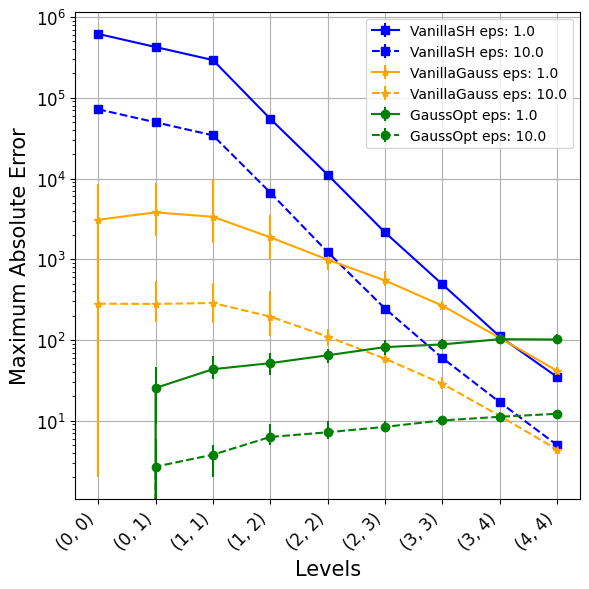

In [12]:
# plot line
import matplotlib.pyplot as plt

array = max_error_dense
fig, ax = plt.subplots(figsize=(6, 6))
for i, mechanism in enumerate(mechanisms):
    for j, epsilon in enumerate(epsilons):
        # plot error bar line for each level using min max
        error = np.array([np.mean(array[i, j], axis=0) - np.min(array[i, j], axis=0),
                          np.max(array[i, j], axis=0) - np.mean(array[i, j], axis=0)])
        ax.errorbar(range(len(levels)), np.mean(array[i, j], axis=0), yerr=error,
                    label=mechanism + f" eps: {epsilon}",
                    fmt=markers[j][i], color=colors[i])
ax.set_yscale("log")
# Setting labels and ticks
ax.set_ylabel("Maximum Absolute Error", fontsize=15)
ax.set_xlabel("Levels", fontsize=15)  # Optional: Add an x-label for clarity
ax.set_xticks(range(len(levels)))
ax.set_xticklabels(levels, rotation=45, ha='right')  # Set oblique labels
# augment font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Display the plot
plt.grid(True)
plt.tight_layout()
# save a version with no legend
plt.savefig(f"../plots/synthetic_data_{type}_branch_{density}/max_error_nolegend.pdf", dpi=300)
# Adding a legend
plt.legend()
# save
plt.tight_layout()
plt.savefig(f"../plots/synthetic_data_{type}_branch_{density}/max_error.pdf", dpi=300)
plt.show()

## Mean Absolute Error per Level

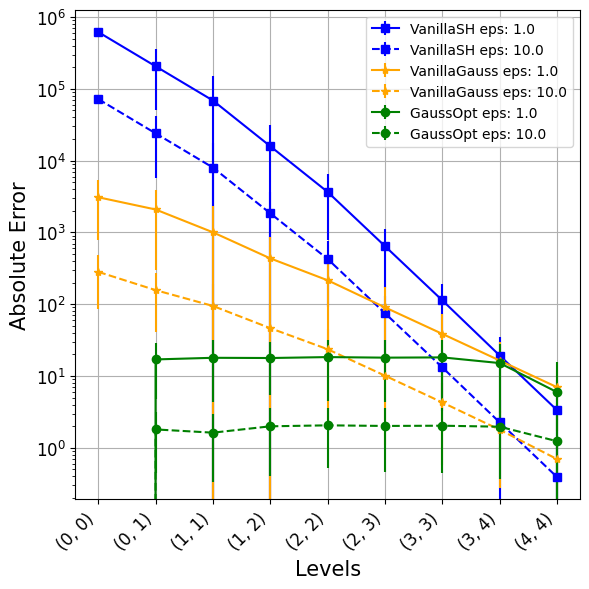

In [13]:
# plot line
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
for i, mechanism in enumerate(mechanisms):
    for j, epsilon in enumerate(epsilons):
        ax.errorbar(range(len(levels)), MAE[i, j], yerr=std[i, j],
                    label=mechanism + f" eps: {epsilon}",
                    fmt=markers[j][i], color=colors[i])
ax.set_yscale("log")
# Setting labels and ticks
ax.set_ylabel("Absolute Error", fontsize=15)
ax.set_xlabel("Levels", fontsize=15)  # Optional: Add an x-label for clarity
ax.set_xticks(range(len(levels)))
ax.set_xticklabels(levels, rotation=45, ha='right')  # Set oblique labels
# augment font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Display the plot
plt.grid(True)
# save a version with no legend
plt.tight_layout()
plt.tight_layout()
plt.savefig(f"../plots/synthetic_data_{type}_branch_{density}/mean_absolute_error_nolegend.pdf", dpi=300)
# Adding a legend
plt.legend()
# save
plt.tight_layout()
plt.savefig(f"../plots/synthetic_data_{type}_branch_{density}/mean_absolute_error.pdf", dpi=300)
plt.show()

## False Discovery Rate

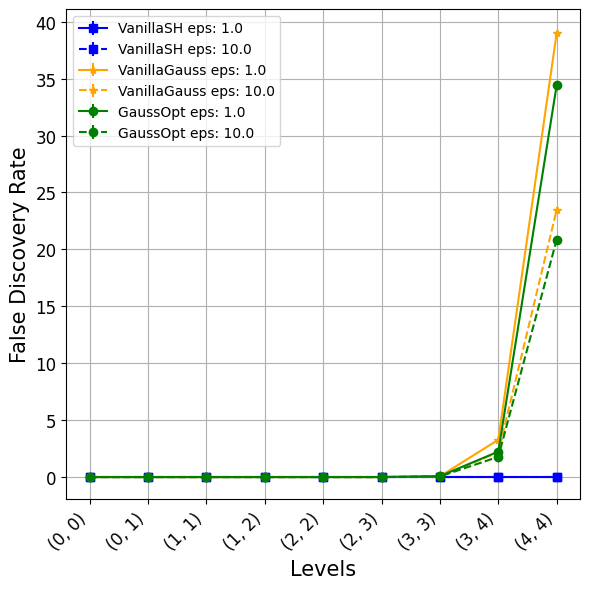

In [14]:
# plot line
import matplotlib.pyplot as plt

array = false_discovery_rate_dense
fig, ax = plt.subplots(figsize=(6, 6))
for i, mechanism in enumerate(mechanisms):
    for j, epsilon in enumerate(epsilons):
        # plot error bar line for each level using min max
        error = np.array([np.mean(array[i, j], axis=0) - np.min(array[i, j], axis=0),
                          np.max(array[i, j], axis=0) - np.mean(array[i, j], axis=0)])
        ax.errorbar(range(len(levels)), np.mean(array[i, j], axis=0), yerr=error,
                    label=mechanism + f" eps: {epsilon}",
                    fmt=markers[j][i], color=colors[i])

# Setting labels and ticks
ax.set_ylabel("False Discovery Rate", fontsize=15)
ax.set_xlabel("Levels", fontsize=15)  # Optional: Add an x-label for clarity
ax.set_xticks(range(len(levels)))
ax.set_xticklabels(levels, rotation=45, ha='right')  # Set oblique labels
# augment font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Display the plot
plt.grid(True)
plt.tight_layout()
plt.savefig(f"../plots/synthetic_data_{type}_branch_{density}/false_discovery_rate_nolegend.pdf", dpi=300)
# Adding a legend
plt.legend()
# save
plt.tight_layout()
plt.savefig(f"../plots/synthetic_data_{type}_branch_{density}/false_discovery_rate.pdf", dpi=300)
plt.show()

## False Negative Rate

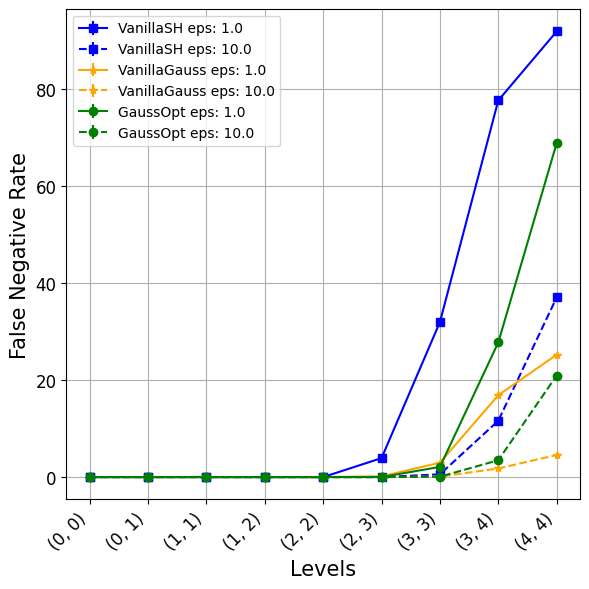

In [15]:
# plot line
import matplotlib.pyplot as plt

array = false_negative_rate_dense
fig, ax = plt.subplots(figsize=(6, 6))
for i, mechanism in enumerate(mechanisms):
    for j, epsilon in enumerate(epsilons):
        # plot error bar line for each level using min max
        error = np.array([np.mean(array[i, j], axis=0) - np.min(array[i, j], axis=0),
                          np.max(array[i, j], axis=0) - np.mean(array[i, j], axis=0)])
        ax.errorbar(range(len(levels)), np.mean(array[i, j], axis=0), yerr=error,
                    label=mechanism + f" eps: {epsilon}",
                    fmt=markers[j][i], color=colors[i])

# Setting labels and ticks
ax.set_ylabel("False Negative Rate", fontsize=15)
ax.set_xlabel("Levels", fontsize=15)  # Optional: Add an x-label for clarity
ax.set_xticks(range(len(levels)))
ax.set_xticklabels(levels, rotation=45, ha='right')  # Set oblique labels
# augment font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Display the plot
plt.grid(True)
plt.tight_layout()
plt.savefig(f"../plots/synthetic_data_{type}_branch_{density}/false_negative_rate_nolegend.pdf", dpi=300)
# Adding a legend
plt.legend()
# save
plt.tight_layout()
plt.savefig(f"../plots/synthetic_data_{type}_branch_{density}/false_negative_rate.pdf", dpi=300)
plt.show()

# Sparse dataset

## Load the data

In [16]:
from data_structure import GeoSpine
from data_structure import HierarchicalData

density = "sparse"
folder_path = f"../data/synthetic_{type}_branching_{density}/"
with open(os.path.join(folder_path, "structure/geo_spine.pickle"), "rb") as f:
    geo_spine = pickle.load(f)

# upload csv data
df = pd.read_csv(os.path.join(folder_path, "data.csv"))

spine = GeoSpine(geo_spine)
H_sparse = HierarchicalData(df, spine)

## Histogram of counts for the finest level

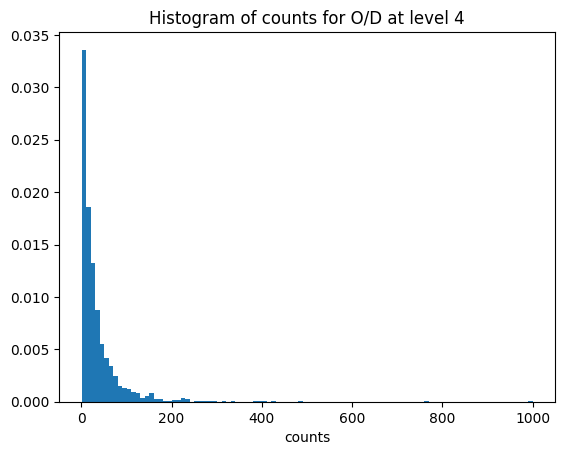

In [17]:
# make historga of count
import matplotlib.pyplot as plt

data_true = H_sparse.data_up_to_level(final_level, as_index=False, dtype=int)
plt.hist(data_true["COUNT"], bins=100, density=True)
plt.title(f"Histogram of counts for O/D at level {final_level}")
plt.xlabel("counts")
plt.show()

In [18]:
print("Sparsity of the data ", 1 - len(data_true) / (len(H_sparse.spine.get_nodes(level=final_level)) ** 2))

Sparsity of the data  0.9900013211784913


## Apply Stability Histogram

In [19]:
import argparse

epsilons = [1., 10.]
delta = 1E-8
num_experiments = 10
levels: list[tuple] = [(i, i) if i == j else (i, j) for i in range(final_level + 1) for j in range(i, i + 2) if
                       j < final_level + 1]

# mechanisms, epsilons, experiments, levels
num_mechanisms = 3
max_error_sparse = np.zeros((num_mechanisms, 2, num_experiments, len(levels)))
false_discovery_rate_sparse = np.zeros((num_mechanisms, 2, num_experiments, len(levels)))
false_negative_rate_sparse = np.zeros((num_mechanisms, 2, num_experiments, len(levels)))
MAE = np.zeros((num_mechanisms, 2, len(levels)))
std = np.zeros((num_mechanisms, 2, len(levels)))

# generate Namespace containing epsilon and delta
args = argparse.Namespace(delta=delta, final_level=final_level, max_contribution=1, show_tqdm=False,
                          optimizer="greedy_integer",
                          p='inf', integer_true=False, split_method='uniform')

In [20]:
from mechanism import VanillaSH
from metrics import analysis

for e, epsilon in enumerate(epsilons):
    args.epsilon = epsilon
    absolute_error_distribution_epsilon = []
    for i in range(num_experiments):
        print(f"Experiment {i + 1}")
        data_vanillash_sparse, running_time_dense = VanillaSH(H_sparse, args)
        absolute_error_distribution = []
        for j, level in enumerate(tqdm.tqdm(levels, colour="green")):
            workload = [[f"LEVEL{level[0]}_ORIG", f"LEVEL{level[1]}_DEST"]]
            analysis_dict = analysis(data_true=data_true,
                                     dp_data=data_vanillash_sparse,
                                     spine=H_sparse.spine,
                                     workload=workload)
            max_error_sparse[0, e, i, j] = analysis_dict["max_absolute_error"]
            false_discovery_rate_sparse[0, e, i, j] = analysis_dict["false_discovery_rate"]
            false_negative_rate_sparse[0, e, i, j] = analysis_dict["false_negative_rate"]
            absolute_error_distribution.append(np.abs(analysis_dict["error_distribution"][0]))
        absolute_error_distribution_epsilon.append(absolute_error_distribution)
        # clear jupyter output on the terminal
        clear_output(wait=True)
    # absolute_error_distribution_epsilon is a list of lists that needs to be concatenated
    error_to_add = np.zeros(len(levels))
    std_to_add = np.zeros(len(levels))
    for j in range(len(levels)):
        concantenation = []
        # concatenate the list of lists
        for i in range(num_experiments):
            concantenation.append(absolute_error_distribution_epsilon[i][j])
        # assert they are all the same length
        assert len(set([len(x) for x in concantenation])) == 1
        # flatten the list
        error_to_add[j] = np.mean(np.concatenate(concantenation))
        std_to_add[j] = np.std(np.concatenate(concantenation))
    MAE[0, e] = error_to_add
    std[0, e] = std_to_add

Experiment 10
Querying the full histogram
Applying the DP mechanism
Creating the dataset
Time taken to create the dataset: 0.15 seconds


100%|██████████| 9/9 [00:00<00:00, 76.92it/s]


## Apply VanillaGauss

In [21]:
from mechanism import VanillaGauss

for e, epsilon in enumerate(epsilons):
    args.epsilon = epsilon
    absolute_error_distribution_epsilon = []
    for i in range(num_experiments):
        print(f"Experiment {i + 1}")
        data_vanillagauss_sparse, running_time_dense = VanillaGauss(H_sparse, args)
        absolute_error_distribution = []
        for j, level in enumerate(tqdm.tqdm(levels, colour="green")):
            workload = [[f"LEVEL{level[0]}_ORIG", f"LEVEL{level[1]}_DEST"]]
            analysis_dict = analysis(data_true=data_true,
                                     dp_data=data_vanillagauss_sparse,
                                     spine=H_sparse.spine,
                                     workload=workload)
            max_error_sparse[1, e, i, j] = analysis_dict["max_absolute_error"]
            false_discovery_rate_sparse[1, e, i, j] = analysis_dict["false_discovery_rate"]
            false_negative_rate_sparse[1, e, i, j] = analysis_dict["false_negative_rate"]
            absolute_error_distribution.append(np.abs(analysis_dict["error_distribution"][0]))
        absolute_error_distribution_epsilon.append(absolute_error_distribution)
        # clear jupyter output on the terminal
        clear_output(wait=True)
    # absolute_error_distribution_epsilon is a list of lists that needs to be concatenated
    error_to_add = np.zeros(len(levels))
    std_to_add = np.zeros(len(levels))
    for j in range(len(levels)):
        concantenation = []
        # concatenate the list of lists
        for i in range(num_experiments):
            concantenation.append(absolute_error_distribution_epsilon[i][j])
        # assert they are all the same length
        assert len(set([len(x) for x in concantenation])) == 1
        # flatten the list
        error_to_add[j] = np.mean(np.concatenate(concantenation))
        std_to_add[j] = np.std(np.concatenate(concantenation))
    MAE[1, e] = error_to_add
    std[1, e] = std_to_add

Experiment 10
Querying the full histogram
Applying the DP mechanism
Creating the dataset
Time taken to create the dataset: 2.10 seconds


100%|██████████| 9/9 [00:01<00:00,  8.62it/s]


## Apply GaussOpt

In [22]:
from mechanism import GaussOpt_destination

for e, epsilon in enumerate(epsilons):
    args.epsilon = epsilon
    absolute_error_distribution_epsilon = []
    for i in range(num_experiments):
        print(f"Experiment {i + 1}")
        data_gaussopt_sparse, running_time_dense = GaussOpt_destination(H_sparse, args)
        absolute_error_distribution = []
        for j, level in enumerate(tqdm.tqdm(levels, colour="green")):
            workload = [[f"LEVEL{level[0]}_ORIG", f"LEVEL{level[1]}_DEST"]]
            analysis_dict = analysis(data_true=data_true,
                                     dp_data=data_gaussopt_sparse,
                                     spine=H_sparse.spine,
                                     workload=workload)
            max_error_sparse[2, e, i, j] = analysis_dict["max_absolute_error"]
            false_discovery_rate_sparse[2, e, i, j] = analysis_dict["false_discovery_rate"]
            false_negative_rate_sparse[2, e, i, j] = analysis_dict["false_negative_rate"]
            absolute_error_distribution.append(np.abs(analysis_dict["error_distribution"][0]))
        absolute_error_distribution_epsilon.append(absolute_error_distribution)
        # clear jupyter output on the terminal
        clear_output(wait=True)
    # absolute_error_distribution_epsilon is a list of lists that needs to be concatenated
    error_to_add = np.zeros(len(levels))
    std_to_add = np.zeros(len(levels))
    for j in range(len(levels)):
        concantenation = []
        # concatenate the list of lists
        for i in range(num_experiments):
            concantenation.append(absolute_error_distribution_epsilon[i][j])
        # assert they are all the same length
        assert len(set([len(x) for x in concantenation])) == 1
        # flatten the list
        error_to_add[j] = np.mean(np.concatenate(concantenation))
        std_to_add[j] = np.std(np.concatenate(concantenation))
    MAE[2, e] = error_to_add
    std[2, e] = std_to_add

Experiment 10
Level orig 0/4, Level dest 1/4 performing optimization...
Level orig 1/4, Level dest 1/4 performing optimization...
Level orig 1/4, Level dest 2/4 performing optimization...
Level orig 2/4, Level dest 2/4 performing optimization...
Level orig 2/4, Level dest 3/4 performing optimization...
Level orig 3/4, Level dest 3/4 performing optimization...
Level orig 3/4, Level dest 4/4 performing optimization...
Level orig 4/4, Level dest 4/4 performing optimization...
Time taken to create the dataset: 6.26 seconds
Done!


100%|██████████| 9/9 [00:00<00:00, 62.32it/s]


## Maximum Absolute Error per Level

In [23]:
mechanisms = ["VanillaSH", "VanillaGauss", "GaussOpt"]
markers = [["-s", "-*", "-o"], ["--s", "--*", "--o"]]
colors = ["blue", "orange", "green"]
density="sparse"

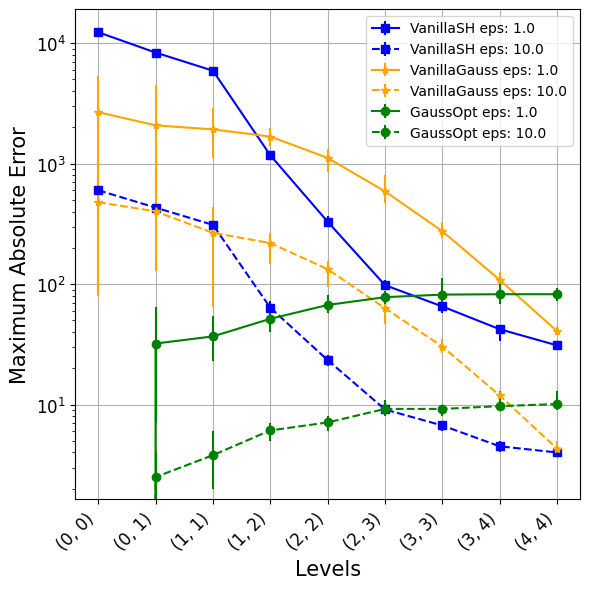

In [24]:
# plot line
import matplotlib.pyplot as plt

array = max_error_sparse
fig, ax = plt.subplots(figsize=(6, 6))
for i, mechanism in enumerate(mechanisms):
    for j, epsilon in enumerate(epsilons):
        # plot error bar line for each level using min max
        error = np.array([np.mean(array[i, j], axis=0) - np.min(array[i, j], axis=0),
                          np.max(array[i, j], axis=0) - np.mean(array[i, j], axis=0)])
        ax.errorbar(range(len(levels)), np.mean(array[i, j], axis=0), yerr=error,
                    label=mechanism + f" eps: {epsilon}",
                    fmt=markers[j][i], color=colors[i])
ax.set_yscale("log")
# Setting labels and ticks
ax.set_ylabel("Maximum Absolute Error", fontsize=15)
ax.set_xlabel("Levels", fontsize=15)  # Optional: Add an x-label for clarity
ax.set_xticks(range(len(levels)))
ax.set_xticklabels(levels, rotation=45, ha='right')  # Set oblique labels
# augment font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Display the plot
plt.grid(True)
plt.tight_layout()
plt.savefig(f"../plots/synthetic_data_{type}_branch_{density}/max_error_nolegend.pdf", dpi=300)
# Adding a legend
plt.legend()
# save
plt.tight_layout()
plt.savefig(f"../plots/synthetic_data_{type}_branch_{density}/max_error.pdf", dpi=300)
plt.show()

## Mean Absolute Error per Level

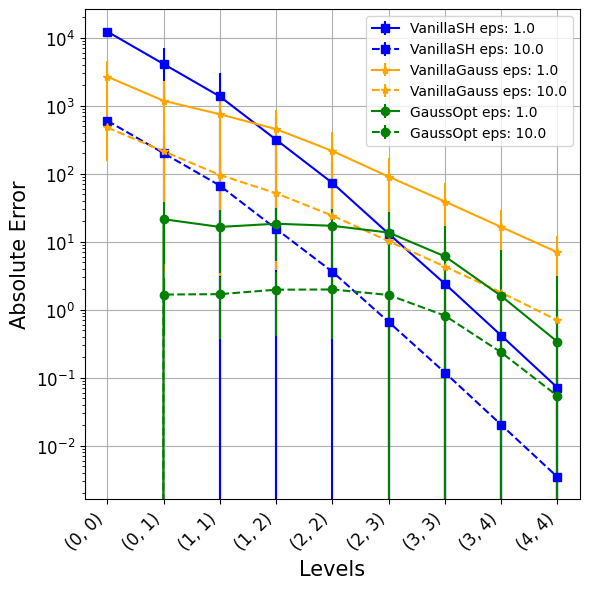

In [25]:
# plot line
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
for i, mechanism in enumerate(mechanisms):
    for j, epsilon in enumerate(epsilons):
        ax.errorbar(range(len(levels)), MAE[i, j], yerr=std[i, j],
                    label=mechanism + f" eps: {epsilon}",
                    fmt=markers[j][i], color=colors[i])
ax.set_yscale("log")
# Setting labels and ticks
ax.set_ylabel("Absolute Error", fontsize=15)
ax.set_xlabel("Levels", fontsize=15)  # Optional: Add an x-label for clarity
ax.set_xticks(range(len(levels)))
ax.set_xticklabels(levels, rotation=45, ha='right')  # Set oblique labels
# augment font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Display the plot
plt.grid(True)
plt.tight_layout()
plt.savefig(f"../plots/synthetic_data_{type}_branch_{density}/mean_absolute_error_nolegend.pdf", dpi=300)
# Adding a legend
plt.legend()
# save
plt.tight_layout()
plt.savefig(f"../plots/synthetic_data_{type}_branch_{density}/mean_absolute_error.pdf", dpi=300)
plt.show()

## False Discovery Rate

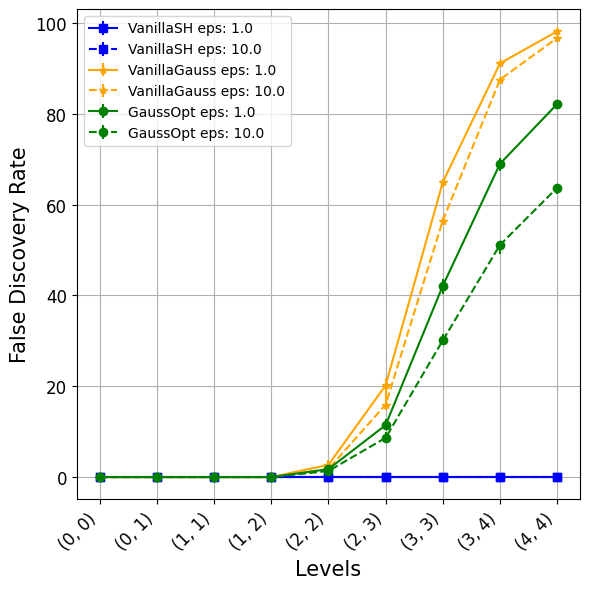

In [26]:
# plot line
import matplotlib.pyplot as plt

array = false_discovery_rate_sparse
fig, ax = plt.subplots(figsize=(6, 6))
for i, mechanism in enumerate(mechanisms):
    for j, epsilon in enumerate(epsilons):
        # plot error bar line for each level using min max
        error = np.array([np.mean(array[i, j], axis=0) - np.min(array[i, j], axis=0),
                          np.max(array[i, j], axis=0) - np.mean(array[i, j], axis=0)])
        error = np.abs(error)
        ax.errorbar(range(len(levels)), np.mean(array[i, j], axis=0), yerr=error,
                    label=mechanism + f" eps: {epsilon}",
                    fmt=markers[j][i], color=colors[i])

# Setting labels and ticks
ax.set_ylabel("False Discovery Rate", fontsize=15)
ax.set_xlabel("Levels", fontsize=15)  # Optional: Add an x-label for clarity
ax.set_xticks(range(len(levels)))
ax.set_xticklabels(levels, rotation=45, ha='right')  # Set oblique labels
# augment font size 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Display the plot
plt.grid(True)
plt.tight_layout()
plt.savefig(f"../plots/synthetic_data_{type}_branch_{density}/false_discovery_rate_nolegend.pdf", dpi=300)
# Adding a legend
plt.legend()
# save
plt.tight_layout()
plt.savefig(f"../plots/synthetic_data_{type}_branch_{density}/false_discovery_rate.pdf", dpi=300)
plt.show()

## False Negative Rate

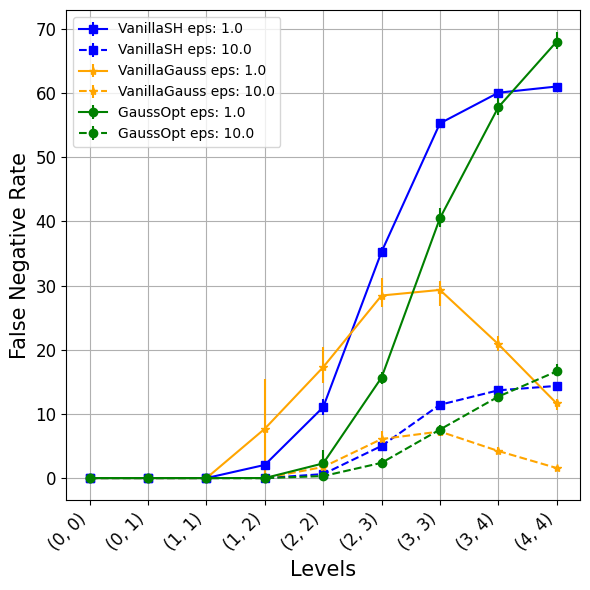

In [27]:
# plot line
import matplotlib.pyplot as plt

array = false_negative_rate_sparse
fig, ax = plt.subplots(figsize=(6, 6))
for i, mechanism in enumerate(mechanisms):
    for j, epsilon in enumerate(epsilons):
        # plot error bar line for each level using min max
        error = np.array([np.mean(array[i, j], axis=0) - np.min(array[i, j], axis=0),
                          np.max(array[i, j], axis=0) - np.mean(array[i, j], axis=0)])
        ax.errorbar(range(len(levels)), np.mean(array[i, j], axis=0), yerr=error,
                    label=mechanism + f" eps: {epsilon}",
                    fmt=markers[j][i], color=colors[i])

# Setting labels and ticks
ax.set_ylabel("False Negative Rate", fontsize=15)
ax.set_xlabel("Levels", fontsize=15)  # Optional: Add an x-label for clarity
ax.set_xticks(range(len(levels)))
ax.set_xticklabels(levels, rotation=45, ha='right')  # Set oblique labels
# augment font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Display the plot
plt.grid(True)
# save
plt.tight_layout()
plt.savefig(f"../plots/synthetic_data_{type}_branch_{density}/false_negative_rate_nolegend.pdf", dpi=300)
# Adding a legend
plt.legend()
plt.savefig(f"../plots/synthetic_data_{type}_branch_{density}/false_negative_rate.pdf", dpi=300)
plt.show()